# Melanoma Detection Assignment - Saravanakumar PERUMAL

##### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 1) Data Reading/Data Understanding

#### Defined the path for both train and test images from dataset. ( Weightage	5 )

#### Importing all the important libraries

In [1]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pathlib
import pandas as pd
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("data/Melanoma/Train")
data_dir_test = pathlib.Path('data/Melanoma/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Load using keras.preprocessing
##### Let's load these images off disk using the helpful image_dataset_from_directory utility.

## 2) Dataset creation : ( Weightage	 10 )
##### Define some parameters for the loader:
##### Created train & validation dataset from the train directory with a batch size of 32 .
##### Resized images to 180*180.(10%)

In [26]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9


In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory (directory = data_dir_train, labels='inferred', label_mode='categorical',batch_size=batch_size,
    image_size=(img_height, img_width) ) 

Found 2239 files belonging to 9 classes.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory (directory = data_dir_test, labels='inferred', label_mode='categorical',batch_size=batch_size,
    image_size=(img_height, img_width) ) 

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [11]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

## 3) Dataset visualisation ( Weightage	5 )
#### 	Created a code to visualize one instance of all the nine classes present in the dataset 

In [12]:
import matplotlib.pyplot as plt

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
def visualize_one_instance_per_class(dataset, class_names):
  """Visualizes one instance of each class from the dataset.

  Args:
    dataset: A tf.data.Dataset containing images and labels.
    class_names: A list of class names.
  """
  class_indices = {}
  for image_batch, label_batch in dataset.take(1):
    for image, label in zip(image_batch, label_batch):
      #print(label)
      index = tf.argmax(label)      
      class_index = int(index)
      if class_index not in class_indices:
        class_indices[class_index] = image
        print(index)

  plt.figure(figsize=(10, 10))
  for i, (class_index, image) in enumerate(class_indices.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[class_index])
    plt.axis("off")
  plt.show()

tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


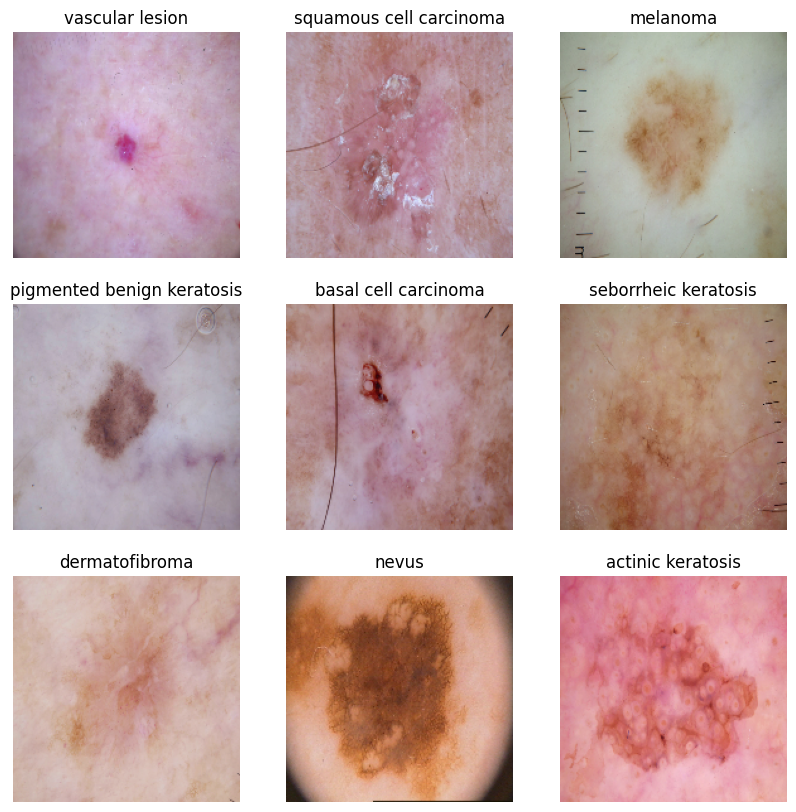

In [14]:
visualize_one_instance_per_class(train_ds, class_names)

## 4 ) Model Building & training 1 (  Weightage	15 )

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model  -- Normalize pixel values between (0,1)
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`
1) Created a CNN model, which can accurately detect 9 classes present in the dataset.
2) Defined appropriate optimiser and loss function for model training.
3) Trained the model for ~20 epochs.
4) Explained the findings after the model fit with evidence if the model overfits or underfits.

In [16]:
for image, label in train_ds.take(1):
    print(image.shape, image.dtype)

(32, 180, 180, 3) <dtype: 'float32'>


### Rescale images

In [129]:
def rescale_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Scale to [0, 1]
    return image, label

In [18]:
train_ds = train_ds.map(rescale_image)

### Validate Normalize pixel values between (0,1) for Training Data

In [19]:
for image, label in train_ds.take(1):
    print(image.numpy().min(), image.numpy().max())  # Should show 0.0 and 1.0 for rescaling

0.0 1.0


tf.Tensor(
[[[0.8163399  0.5627451  0.58431375]
  [0.8117647  0.55441177 0.5651961 ]
  [0.8366014  0.5665032  0.59705883]
  ...
  [0.80588233 0.55310404 0.558824  ]
  [0.7862745  0.5539216  0.54068625]
  [0.78954226 0.5625814  0.5532678 ]]

 [[0.82369286 0.5611111  0.57254905]
  [0.8068628  0.5568628  0.56421566]
  [0.7864379  0.50620914 0.5236928 ]
  ...
  [0.80784315 0.5707516  0.5684646 ]
  [0.7911765  0.5514706  0.5382353 ]
  [0.7913399  0.5472225  0.5339872 ]]

 [[0.79901963 0.5550654  0.54656863]
  [0.8279412  0.5745098  0.575     ]
  [0.825817   0.55245095 0.5816993 ]
  ...
  [0.8065365  0.57205915 0.5707521 ]
  [0.80245095 0.5588235  0.55490196]
  [0.79264724 0.5527781  0.55228764]]

 ...

 [[0.7653595  0.5392157  0.5173203 ]
  [0.7588235  0.54607844 0.5240196 ]
  [0.75571895 0.53954244 0.5362745 ]
  ...
  [0.76013064 0.51683    0.5267973 ]
  [0.74558824 0.51029414 0.52009803]
  [0.7457522  0.5024512  0.5029412 ]]

 [[0.7710784  0.5415033  0.5029412 ]
  [0.75539213 0.5352941  0

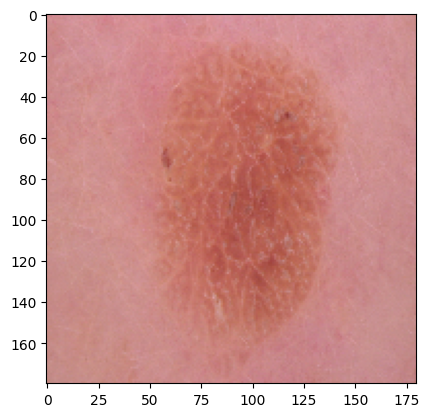

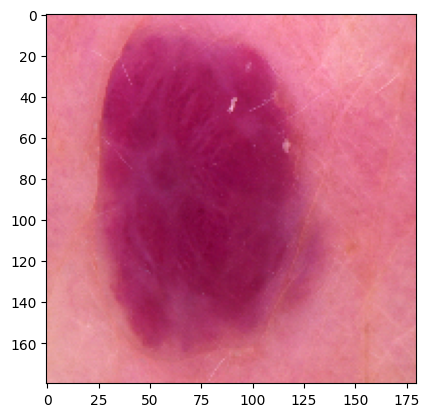

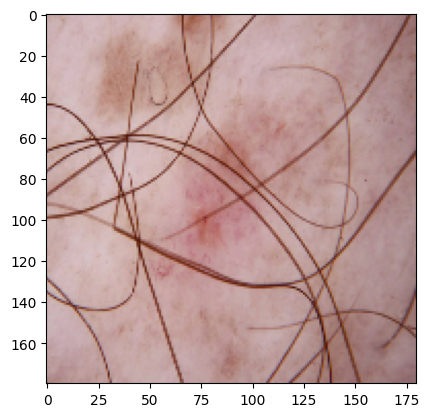

In [20]:
for image, label in train_ds.take(1):
    image = tf.squeeze(image)  # Remove channel dimension if it exists
    print(image[0])  # Should be (height, width)
    # Display the image
    plt.imshow(image[0])  
    plt.show()
    plt.imshow(image[1])  
    plt.show()
    plt.imshow(image[2])  
    plt.show()    
    break

In [21]:
val_ds = val_ds.map(rescale_image)

### Validate Normalize pixel values between (0,1) for Test Data

In [22]:
for image, label in val_ds.take(1):
    print(image.numpy().min(), image.numpy().max())  # Should show 0.0 and 1.0 for rescaling

0.0 1.0


tf.Tensor(
[[[0.7062091  0.40473855 0.3890523 ]
  [0.7151961  0.40980393 0.41960785]
  [0.7119281  0.4472222  0.473366  ]
  ...
  [0.8042485  0.55032647 0.56454206]
  [0.8122549  0.5598039  0.59313726]
  [0.78055567 0.52336633 0.5666668 ]]

 [[0.6754902  0.36977127 0.35      ]
  [0.6720588  0.41666666 0.4622549 ]
  [0.70931375 0.4730392  0.51535946]
  ...
  [0.77614313 0.5379081  0.5393786 ]
  [0.79068625 0.54068625 0.5715686 ]
  [0.7789217  0.5362746  0.57352954]]

 [[0.64330065 0.32859477 0.34297386]
  [0.7058824  0.45294118 0.48578432]
  [0.6934641  0.41911766 0.40261438]
  ...
  [0.7632354  0.5058824  0.5344768 ]
  [0.7848039  0.5416667  0.5681372 ]
  [0.7915032  0.5401962  0.559804  ]]

 ...

 [[0.7820261  0.5305555  0.59411764]
  [0.75735295 0.50784314 0.57990193]
  [0.7821896  0.528268   0.59983665]
  ...
  [0.80310476 0.5772874  0.6246734 ]
  [0.79362744 0.56715685 0.6166667 ]
  [0.7818628  0.5426471  0.6009804 ]]

 [[0.77156866 0.5156863  0.59068626]
  [0.75686276 0.50441176 0

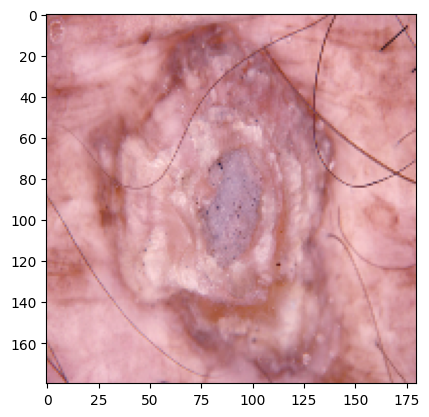

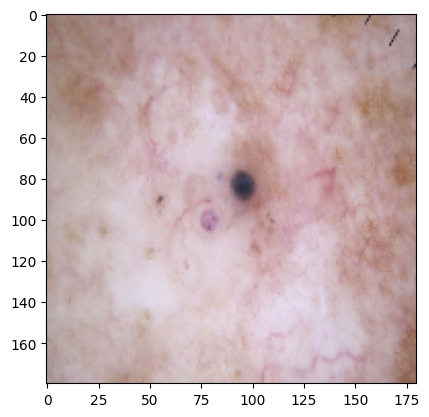

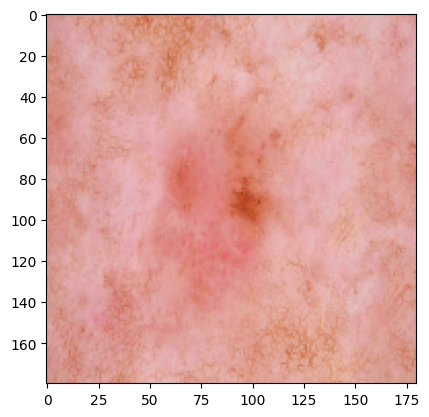

In [23]:
for image, label in val_ds.take(1):
    image = tf.squeeze(image)  # Remove channel dimension if it exists
    print(image[0])  # Should be (height, width)
    # Display the image
    plt.imshow(image[0])  
    plt.show()
    plt.imshow(image[1])  
    plt.show()
    plt.imshow(image[2])  
    plt.show()    
    break

### Basic CNN Model Building 1 -- Without Dropout and Without Batch Normalization

In [27]:
#Basic CNN Model 1 : epochs - 20
epochs = 20
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=( 180, 180, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [28]:
# summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,658,729 (231.39 MB)

 Trainable params: 60,658,729 (231.39 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [157]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [158]:
val_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [32]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 322ms/step - accuracy: 0.6594 - loss: 1.0052 - val_accuracy: 0.3390 - val_loss: 2.7695
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 307ms/step - accuracy: 0.6717 - loss: 0.9165 - val_accuracy: 0.3559 - val_loss: 2.4414
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 298ms/step - accuracy: 0.6840 - loss: 0.8323 - val_accuracy: 0.3983 - val_loss: 2.5567
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 318ms/step - accuracy: 0.7384 - loss: 0.7306 - val_accuracy: 0.3644 - val_loss: 2.7480
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - accuracy: 0.7226 - loss: 0.7358 - val_accuracy: 0.3729 - val_loss: 2.8529
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.7453 - loss: 0.6913 - val_accuracy: 0.3475 - val_loss: 2.7550
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.7243 - loss: 0.7373 - val_accuracy: 0.3898 - val_loss: 2.7239
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.7936 - loss: 0.5589 - val_accu

### Visualizing the results

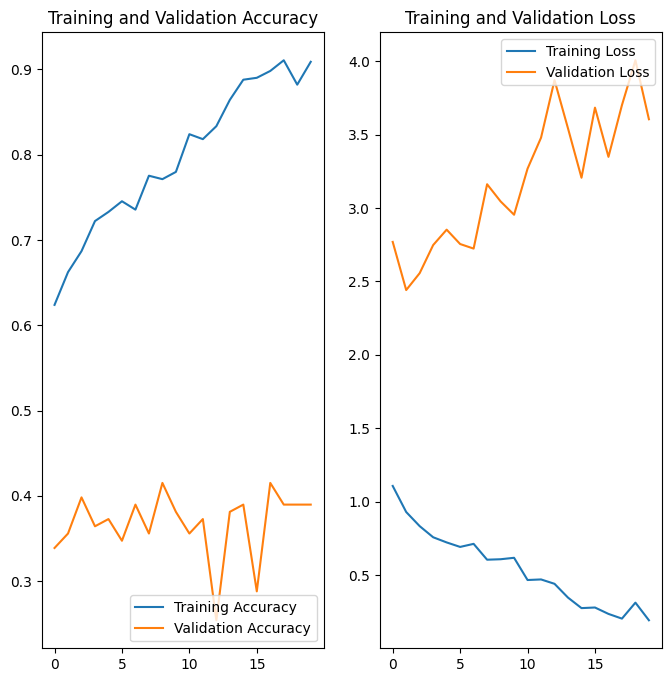

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit.

### Conclusion 1 : 
####    This first basic CNN model is  **overfit**.
####    Training accuracy is : 0.9125 
####    Validation accuracy is : 0.3898 almost constant on each Epoch and it does not improve
####    Training accuracy very high compared to validation accuracy which means that the model memorized the training data but failed to predict the test data
####    Validation loss is increasing for each Epoch and it should reduce for a good CNN model
####    This is not a good CNN model for Melanoma Detection

# 5) Data augmentation (Weightage 10 )
### Data augmentation - Detailed data augmentation is done using **Augmentor** library in following sections.
#### Chose an appropriate data augmentation strategy to resolve underfitting/overfitting 
#### Find the distribution of classes in the training dataset
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

# 6) Model Building 2 -- Use Dropout, Batch Normalization, l2 Regularization along with more CNN layers - ( Weightage 15)

In [34]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=( 180, 180, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [35]:
# summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 26,508,329 (101.12 MB)

 Trainable params: 26,507,433 (101.12 MB)

 Non-trainable params: 896 (3.50 KB)

In [36]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [37]:
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 60s 820ms/step - accuracy: 0.2867 - loss: 16.3098 - val_accuracy: 0.1356 - val_loss: 15.3317
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 57s 819ms/step - accuracy: 0.4583 - loss: 11.3919 - val_accuracy: 0.1356 - val_loss: 17.9671
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 57s 821ms/step - accuracy: 0.4900 - loss: 11.0191 - val_accuracy: 0.1356 - val_loss: 16.2203
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 57s 820ms/step - accuracy: 0.5454 - loss: 10.6304 - val_accuracy: 0.1356 - val_loss: 15.2920
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 832ms/step - accuracy: 0.5439 - loss: 10.3410 - val_accuracy: 0.1949 - val_loss: 13.8304
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 829ms/step - accuracy: 0.5922 - loss: 10.0261 - val_accuracy: 0.2034 - val_loss: 13.6607
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 826ms/step - accuracy: 0.6059 - loss: 9.7320 - val_accuracy: 0.2966 - val_loss: 12.9206
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 830ms/step - accuracy: 0.6317 - loss: 9.38

### Visualizing the results

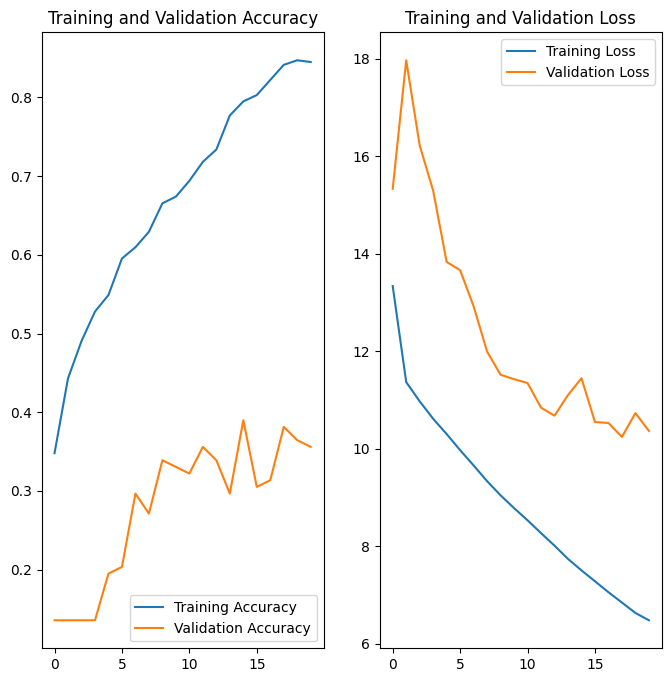

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Conclusion 2 : 
####    This second CNN model with Dropout, Batch Normalization, l2 Regularization and more CNN layers is also **overfit** model.
####    Training accuracy is : 0.8566
####    Validation accuracy is : 0.3559 wich is improved slightly and becomes constant
####    Training accuracy very high compared to validation accuracy which means that the model memorized the training data but failed to predict the test data
####    Validation loss is decreasing for each Epoch and it is a good sign and more Epochs may help to improve the CNN model
####    This second CNN model also not godd for Melanoma Detection

# 7) Class distribution ( Weightage 10 )

In [41]:
#'train_ds' is your prefetched dataset
class_counts = {}
for x, y in train_ds:
    for label in y:
        #class_label = int(label.numpy())
        index = tf.argmax(label)      
        class_label = int(index)
        class_counts[class_label] = class_counts.get(class_label, 0) + 1

print(class_counts)

{3: 438, 4: 357, 1: 376, 7: 181, 5: 462, 6: 77, 2: 95, 0: 114, 8: 139}


In [42]:
# 'val_ds' is your prefetched dataset
class_counts = {}
for x, y in val_ds:
    for label in y:
        #class_label = int(label.numpy())
        index = tf.argmax(label)      
        class_label = int(index)
        class_counts[class_label] = class_counts.get(class_label, 0) + 1

print(class_counts)

{7: 16, 4: 16, 0: 16, 5: 16, 2: 16, 1: 16, 6: 3, 8: 3, 3: 16}


# 8 ) Handling class imbalances - Rectified class imbalances present in the training dataset with Augmentor library ( Weightage 10 )

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
####   Seborrheic keratosis class is having least number of samples which has 77 images.
#### - Which classes dominate the data in terms proportionate number of samples?
####   Pigmented benign keratosis class dominate the data in terms of samples which has 462 images.
### **These results shows that these classes are highly imbalance data wich resulted earlier in poor CNN Model**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [46]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    new_path = str(path_to_training_dataset)+"/"+i
    p = Augmentor.Pipeline(new_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to data\Melanoma\Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E16546B790>: 100%|█| 500/500 [00:02<00:


Initialised with 376 image(s) found.
Output directory set to data\Melanoma\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E164499590>: 100%|█| 500/500 [00:02<00:00, 208.37 Samples


Initialised with 95 image(s) found.
Output directory set to data\Melanoma\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E164488C50>: 100%|█| 500/500 [00:02<00:00, 221.93 Samples


Initialised with 438 image(s) found.
Output directory set to data\Melanoma\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E15F649250>: 100%|█| 500/500 [00:10<00:00, 49.39 Samples


Initialised with 357 image(s) found.
Output directory set to data\Melanoma\Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x1E1643A5390>: 100%|█| 500/500 [00:09<0


Initialised with 462 image(s) found.
Output directory set to data\Melanoma\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E16438D5D0>: 100%|█| 500/500 [00:02<00:00, 221.59 Samples


Initialised with 77 image(s) found.
Output directory set to data\Melanoma\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E1601E1050>: 100%|█| 500/500 [00:05<00:00, 99.88 Samples


Initialised with 181 image(s) found.
Output directory set to data\Melanoma\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E15F6BFF10>: 100%|█| 500/500 [00:02<00:00, 227.65 Samples


Initialised with 139 image(s) found.
Output directory set to data\Melanoma\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E16546F790>: 100%|█| 500/500 [00:02<00:00, 220.18 Samples


In [47]:
path_to_testing=data_dir_test
import Augmentor
for i in class_names:
    new_path = str(path_to_testing)+"/"+i
    p = Augmentor.Pipeline(new_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(100) ## We are adding 100 samples per class for validation to make sure that none of the classes are sparse.

Initialised with 16 image(s) found.
Output directory set to data\Melanoma\Test/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E1643BDFD0>: 100%|█| 100/100 [00:00<00:


Initialised with 16 image(s) found.
Output directory set to data\Melanoma\Test/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E1644AA050>: 100%|█| 100/100 [00:00<00:00, 214.32 Samples


Initialised with 16 image(s) found.
Output directory set to data\Melanoma\Test/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4288x2848 at 0x1E16434A350>: 100%|█| 100/100 [00:10<0


Initialised with 16 image(s) found.
Output directory set to data\Melanoma\Test/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1022x767 at 0x1E1601E5BD0>: 100%|█| 100/100 [00:01<00:00, 54.97 Samples


Initialised with 16 image(s) found.
Output directory set to data\Melanoma\Test/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1022x767 at 0x1E16544D250>: 100%|█| 100/100 [00:01<00


Initialised with 16 image(s) found.
Output directory set to data\Melanoma\Test/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E16440FE50>: 100%|█| 100/100 [00:00<00:00, 191.36 Samples


Initialised with 3 image(s) found.
Output directory set to data\Melanoma\Test/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E16544F190>: 100%|█| 100/100 [00:00<00:00, 101.61 Sample


Initialised with 16 image(s) found.
Output directory set to data\Melanoma\Test/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6641x4391 at 0x1E16438EF50>: 100%|█| 100/100 [00:11<0


Initialised with 3 image(s) found.
Output directory set to data\Melanoma\Test/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E15F6B7250>: 100%|█| 100/100 [00:00<00:00, 216.41 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [48]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [49]:
image_count_test = len(list(data_dir_test.glob('*/output/*.jpg')))
print(image_count_test)

900


Lets see the distribution of augmented data after adding new images to the original training data

In [57]:
import glob as glob1
import os


In [59]:
path_list_train = [x for x in glob1.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_train

['data\\Melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2116e6fa-2e93-4bbc-8087-3d7973c700f6.jpg',
 'data\\Melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_36303ea9-16d9-4763-8431-07d8742ddd92.jpg',
 'data\\Melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_45243b8e-14bc-478a-b1ba-4b17417d2917.jpg',
 'data\\Melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6d310b3b-8f0e-46ef-9a4f-ed17d6770059.jpg',
 'data\\Melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7f8d6d9d-fa9a-4f71-9368-8358ea2f65e6.jpg',
 'data\\Melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8c8d26ce-739a-4750-a5ff-6a3da850c902.jpg',
 'data\\Melanoma\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_90c92853-b331-4349-b49c-d5729892a5d3.jpg',
 'data\\Melanoma\\Train\\ac

In [60]:
lesion_list_new_train = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob1.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new_train

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [61]:
dataframe_dict_new_train = dict(zip(path_list_train, lesion_list_new_train))

In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new_train.items()),columns = ['Path','Label'])

In [64]:
df2.columns

Index(['Path', 'Label'], dtype='object')

In [65]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# 9) Model Building & training- using augmented data (Weightage 15)

In [37]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training datase

In [66]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train_aug = pathlib.Path("data/Melanoma/TrainAugmented")
# Only training set is split into 80 % -Training   and 20 % Validation

#As of now we are ignoring the validation data provided in this data set
#data_dir_test_aug = pathlib.Path('data/Melanoma/TestAugmented')


In [67]:

image_count_train_aug = len(list(data_dir_train_aug.glob('*/*.jpg')))
print(image_count_train_aug)
#image_count_test_aug = len(list(data_dir_test_aug.glob('*/*.jpg')))
#print(image_count_test_aug)

6739


In [68]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

In [69]:
#data_dir_train_aug="path to directory with training data + data created using augmentor"
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  labels='inferred', 
  label_mode='categorical',  
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [71]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  labels='inferred', 
  label_mode='categorical',  
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [72]:
val_ds_aug

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [73]:
train_ds_aug

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [74]:
class_names_aug = train_ds_aug.class_names
print(class_names_aug)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [75]:
len(class_names_aug)

9

In [76]:
class_names_aug_val = val_ds_aug.class_names
print(class_names_aug_val)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [77]:
len(class_names_aug_val)

9

In [78]:
Total = 5392 + 1347
print(Total)

6739


In [79]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [80]:
train_ds_aug

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [81]:
def rescale_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Scale to [0, 1]
    return image, label

In [82]:
train_ds_aug = train_ds_aug.map(rescale_image)
for image, label in train_ds_aug.take(5):
    print(image.numpy().min(), image.numpy().max())  # Should show 0.0 and 1.0 for rescaling


0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [83]:
val_ds_aug = val_ds_aug.map(rescale_image)
for image, label in val_ds_aug.take(5):
    print(image.numpy().min(), image.numpy().max())  # Should show 0.0 and 1.0 for rescaling

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [84]:
train_ds_aug

<_MapDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

##### Note : We should note that we should not run the rescale_image second time !!!

### Model Building 3 --Augmentor Data set, Dropout, Batch Normalization, l2 Regularization along with more CNN layers

In [85]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=( 180, 180, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [86]:
print(num_classes)

9


In [87]:
# summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 26,508,329 (101.12 MB)

 Trainable params: 26,507,433 (101.12 MB)

 Non-trainable params: 896 (3.50 KB)

In [88]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [89]:
for image, label in train_ds_aug.take(1):
    print(image.shape, image.dtype)

(32, 180, 180, 3) <dtype: 'float32'>


In [90]:
for image, label in val_ds_aug.take(1):
    print(image.shape, image.dtype)

(32, 180, 180, 3) <dtype: 'float32'>


In [91]:
epochs = 20

In [92]:
history_aug = model.fit(train_ds_aug, epochs=epochs, validation_data=val_ds_aug)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 152s 891ms/step - accuracy: 0.2690 - loss: 15.8763 - val_accuracy: 0.1433 - val_loss: 15.0418
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 146s 864ms/step - accuracy: 0.4815 - loss: 10.8389 - val_accuracy: 0.2086 - val_loss: 12.7433
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 143s 848ms/step - accuracy: 0.5650 - loss: 10.0211 - val_accuracy: 0.4172 - val_loss: 10.7227
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 145s 861ms/step - accuracy: 0.6434 - loss: 9.2933 - val_accuracy: 0.6132 - val_loss: 9.1633
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 147s 868ms/step - accuracy: 0.7077 - loss: 8.5888 - val_accuracy: 0.6830 - val_loss: 8.4868
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 146s 863ms/step - accuracy: 0.7645 - loss: 7.9905 - val_accuracy: 0.6986 - val_loss: 7.9661
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 149s 880ms/step - accuracy: 0.7969 - loss: 7.4411 - val_accuracy: 0.5382 - val_loss: 8.2264
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 146s 866ms/step - accuracy: 0.

### Visualizing the results

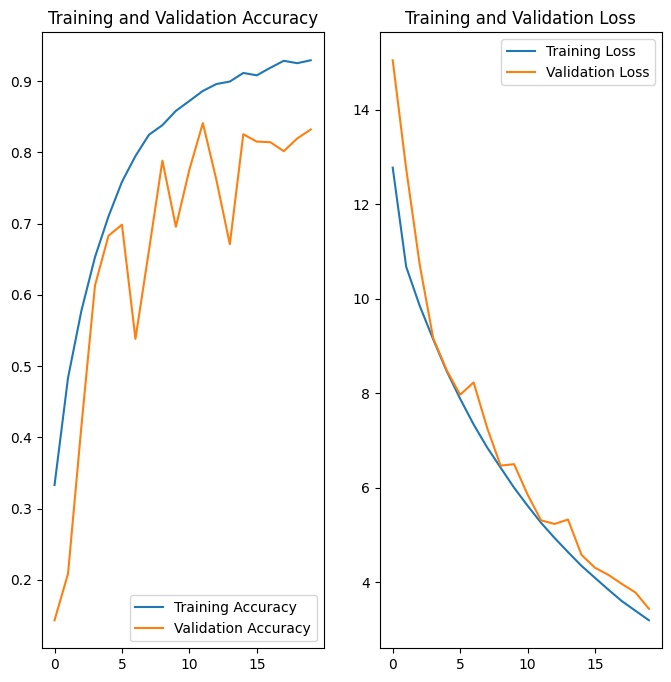

In [93]:
history = history_aug
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 10 ) Conclusions

####    This final CNN model with Data Augmentation, Dropout, Batch Normalization, l2 Regularization and with more CNN layers is a good CNN model.
####    Training accuracy is : 0.9283
####    Validation accuracy is : 0.8322 
####    Training accuracy and Validation Accuracy is steadily increasing for each Epoch
####    Training loss and Validation loss is steadily decreasing for each Epoch
####    Data augmentation and handling class imbalance helped to achive this good model
####    This final CNN model is good model for Melanoma Detection